In [51]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

# Load Data

In [52]:
transit_survey_video = pd.read_csv('Data/transit_survey_agencies_video_v2.csv')
transit_survey_video = transit_survey_video.drop(0)
transit_survey_video['Video/ Audio'] = transit_survey_video['Video/ Audio'].str.lower()
transit_survey_video.head()

transit_survey_video['post_video'] = 0
transit_survey_video.loc[transit_survey_video['Count - video(past 12 months)']>12, 'post_video'] = 1
transit_survey_video.head()

responded = transit_survey_video[transit_survey_video['survey_response'] == 1]
no_response = transit_survey_video[transit_survey_video['survey_response'] == 0]

# Data Exploratory

Text(0.5, 1.0, 'Meeting video platform')

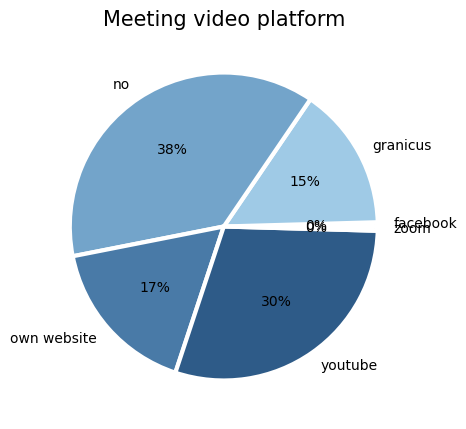

In [53]:
# Have video recoding posted online or not
plt.figure(figsize = (5,5))
plt.pie(transit_survey_video['Video/ Audio'].value_counts().sort_index(), 
    labels = transit_survey_video['Video/ Audio'].value_counts().sort_index().index.tolist(), 
    autopct='%.0f%%',
    wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' },
    colors = ["#B9DDF1", "#9FCAE6", "#73A4CA", "#497AA7", "#2E5B88"])
plt.title('Meeting video platform', fontsize = 15)

Text(0.5, 1.0, 'Transit relevent content')

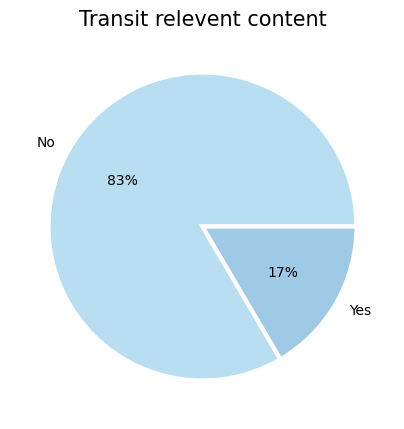

In [54]:
# Has transit relevent meterials?
plt.figure(figsize = (5,5))
plt.pie(transit_survey_video['Transit relevent ?'].value_counts().sort_index(), 
    labels = transit_survey_video['Transit relevent ?'].value_counts().sort_index().index.tolist(), 
    autopct='%.0f%%',
    wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' },
    colors = ["#B9DDF1", "#9FCAE6", "#73A4CA", "#497AA7", "#2E5B88"])
plt.title('Transit relevent content', fontsize = 15)


Text(0.5, 1.0, 'Number of video posted')

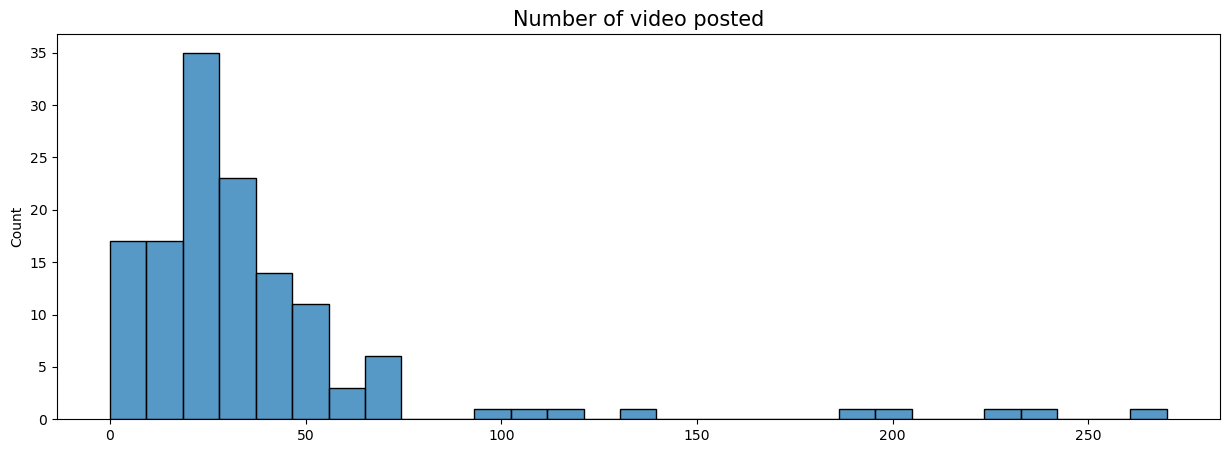

In [55]:
# Number of videos posted in the past 12 months
plt.figure(figsize = (15,5))
sns.histplot(data = np.array(transit_survey_video['Count - video(past 12 months)']))
plt.title('Number of video posted', fontsize = 15)

# Survey Result

## EDA

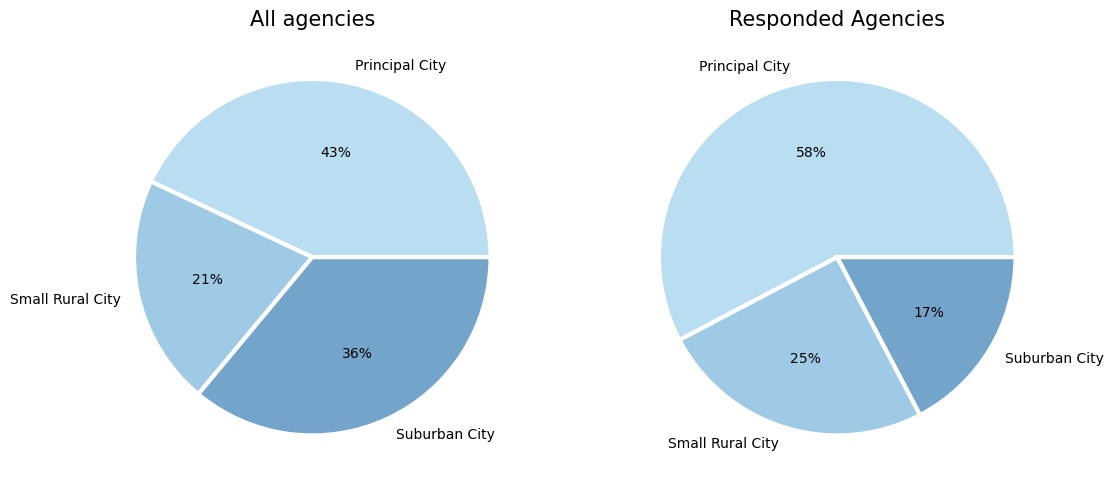

In [56]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

plt.subplot(121)
plt.pie(transit_survey_video['id'].value_counts().sort_index(), 
    labels = transit_survey_video['id'].value_counts().sort_index().index.tolist(), 
    autopct='%.0f%%', 
    wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' },
    colors = ["#B9DDF1", "#9FCAE6", "#73A4CA", "#497AA7", "#2E5B88"])
plt.title('All agencies', fontsize = 15)

plt.subplot(122)
plt.pie(responded['id'].value_counts().sort_index(), 
    labels = responded['id'].value_counts().sort_index().index.tolist(), 
    autopct='%.0f%%', 
    wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' },
    colors = ["#B9DDF1", "#9FCAE6", "#73A4CA", "#497AA7", "#2E5B88"])
plt.title('Responded Agencies', fontsize = 15)

plt.tight_layout()

plt.savefig('Result/Survey type of city.jpg', dpi = 300)


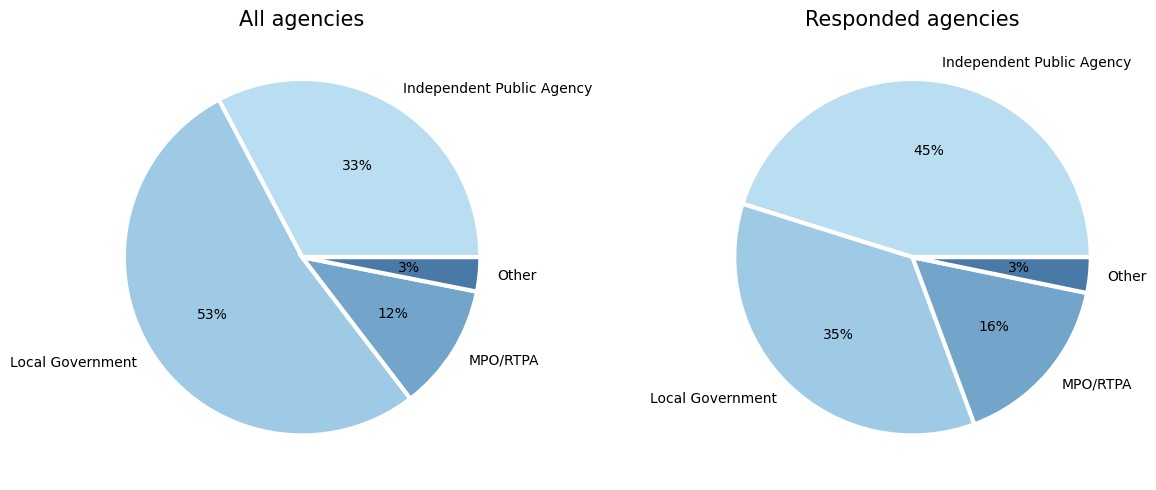

In [57]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

plt.subplot(121)
plt.pie(transit_survey_video['orgtype'].value_counts().sort_index(), 
        labels = transit_survey_video['orgtype'].value_counts().sort_index().index.tolist(), 
        autopct='%.0f%%',
        wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' },
        colors = ["#B9DDF1", "#9FCAE6", "#73A4CA", "#497AA7", "#2E5B88"])
plt.title('All agencies', fontsize = 15)

plt.subplot(122)
plt.pie(responded['orgtype'].value_counts().sort_index(), 
        labels = responded['orgtype'].value_counts().sort_index().index.tolist(), 
        autopct='%.0f%%',
        wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' },
        colors = ["#B9DDF1", "#9FCAE6", "#73A4CA", "#497AA7", "#2E5B88"])
plt.title('Responded agencies', fontsize = 15)

plt.tight_layout()

plt.savefig('Result/Survey type of agency.jpg', dpi = 300)

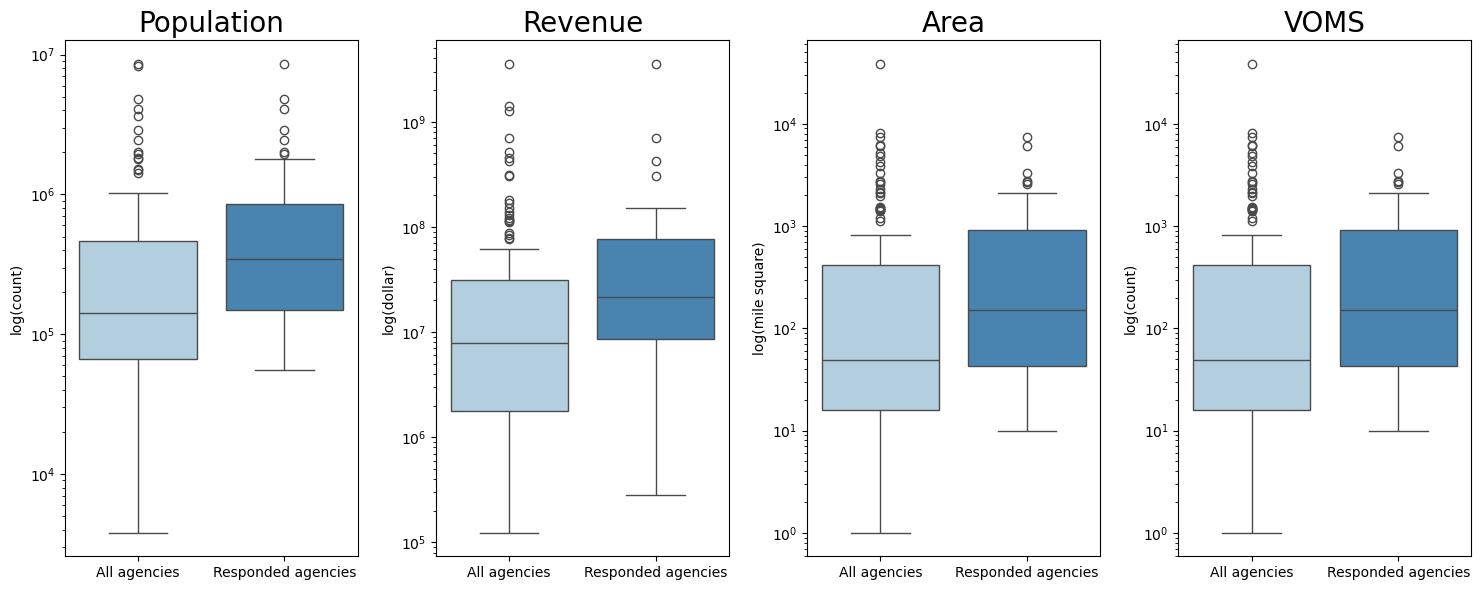

In [58]:
fig, axes = plt.subplots(1, 4, figsize=(15, 6))

plt.subplot(141)
pop = pd.concat([transit_survey_video['pop'].reset_index(drop = True).rename('All agencies'),
                 responded['pop'].reset_index(drop = True).rename('Responded agencies')], axis = 1)
                #  no_response['pop'].reset_index(drop = True).rename('No_response')], axis = 1)
sns.boxplot(data = pop, palette="Blues")
plt.title('Population', fontsize = 20)
plt.ylabel('log(count)')
plt.yscale('log')

plt.subplot(142)
rev = pd.concat([transit_survey_video['revenue'].reset_index(drop = True).rename('All agencies'),
                 responded['revenue'].reset_index(drop = True).rename('Responded agencies')], axis = 1)
                #  no_response['pop'].reset_index(drop = True).rename('No_response')], axis = 1)
sns.boxplot(data = rev, palette="Blues")
plt.title('Revenue', fontsize = 20)
plt.ylabel('log(dollar)')
plt.yscale('log')

plt.subplot(143)
mile = pd.concat([transit_survey_video['mile'].reset_index(drop = True).rename('All agencies'),
                 responded['mile'].reset_index(drop = True).rename('Responded agencies')], axis = 1)
                #  no_response['pop'].reset_index(drop = True).rename('No_response')], axis = 1)
sns.boxplot(data = mile, palette="Blues")
plt.title('Area', fontsize = 20)
plt.ylabel('log(mile square)')
plt.yscale('log')

plt.subplot(144)
voms = pd.concat([transit_survey_video['VOMS'].reset_index(drop = True).rename('All agencies'),
                 responded['VOMS'].reset_index(drop = True).rename('Responded agencies')], axis = 1)
                #  no_response['pop'].reset_index(drop = True).rename('No_response')], axis = 1)
sns.boxplot(data = mile, palette="Blues")
plt.title('VOMS', fontsize = 20)
plt.ylabel('log(count)')
plt.yscale('log')

plt.tight_layout()

plt.savefig('Result/Survey agencies size.jpg', dpi = 300)

## Linear Regression

In [59]:
# Note that only NTD reporters have attributes (pop, mile, VOMS, revenue)

log_meta = np.log(transit_survey_video[['pop', 'mile', 'VOMS', 'revenue']]).dropna()
log_meta[['survey_response','post_video']] = transit_survey_video[['survey_response','post_video']]
log_meta

/Users/Bird/miniforge3/envs/env_tensorflow/lib/python3.9/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


,pop,mile,VOMS,revenue,survey_response,post_video
2,14.169875,5.897154,6.677083,20.069671,0.0,1
3,11.327668,2.079442,2.708050,14.453757,0.0,1
5,15.225205,3.332205,3.526361,17.497859,1.0,0
7,12.788288,3.912023,4.343805,16.648162,1.0,0
8,12.762970,7.090077,4.304065,17.333171,1.0,0
...,...,...,...,...,...,...
219,11.586492,2.772589,2.079442,14.079199,0.0,1
220,10.471298,0.693147,2.302585,14.517015,0.0,1
221,11.080988,2.995732,3.912023,16.251056,0.0,0
223,13.178517,4.691348,3.912023,16.701106,0.0,0


In [60]:
'''
Y(survey_response) = a x log(pop) + c
'''

Y = log_meta['survey_response']
X = log_meta[['pop']]
X = sm.add_constant(X)

results = sm.OLS(Y,X).fit()
results.summary()  


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        survey_response   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     20.83
Date:                Tue, 21 Nov 2023   Prob (F-statistic):           1.17e-05
Time:                        10:28:20   Log-Likelihood:                -73.783
No. Observations:                 129   AIC:                             151.6
Df Residuals:                     127   BIC:                             157.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1295      0.318     -3.555      0.001      -1.758      -0.501
pop            0.1192      0.026      4.564      0.000       0.068       0.171
==============================================================================
Omnibus:                       30.028   Durbin-Watson:                   1.607
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.184
Skew:                           0.588   Prob(JB):                      0.00137
Kurtosis:                       1.965   Cond. No.                         102.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
'''
Y(survey_response) = a x log(revenue) + c
'''

Y = log_meta['survey_response']
X = log_meta[['revenue']]
X = sm.add_constant(X)

results = sm.OLS(Y,X).fit()
results.summary()  


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        survey_response   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     16.55
Date:                Tue, 21 Nov 2023   Prob (F-statistic):           8.26e-05
Time:                        10:28:20   Log-Likelihood:                -75.676
No. Observations:                 129   AIC:                             155.4
Df Residuals:                     127   BIC:                             161.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8950      0.299     -2.996      0.003      -1.486      -0.304
revenue        0.0754      0.019      4.068      0.000       0.039       0.112
==============================================================================
Omnibus:                       36.507   Durbin-Watson:                   1.561
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               14.184
Skew:                           0.603   Prob(JB):                     0.000832
Kurtosis:                       1.911   Cond. No.                         125.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
'''
Y(survey_response) = a x log(mile) + c
'''

Y = log_meta['survey_response']
X = log_meta[['mile']]
X = sm.add_constant(X)

results = sm.OLS(Y,X).fit()
results.summary()  


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        survey_response   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     23.23
Date:                Tue, 21 Nov 2023   Prob (F-statistic):           4.03e-06
Time:                        10:28:21   Log-Likelihood:                -72.742
No. Observations:                 129   AIC:                             149.5
Df Residuals:                     127   BIC:                             155.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0866      0.091     -0.957      0.341      -0.266       0.093
mile           0.1016      0.021      4.820      0.000       0.060       0.143
==============================================================================
Omnibus:                       25.756   Durbin-Watson:                   1.592
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               12.835
Skew:                           0.595   Prob(JB):                      0.00163
Kurtosis:                       2.014   Cond. No.                         10.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:
'''
Y(survey_response) = a x log(VOMS) + c
'''

Y = log_meta['survey_response']
X = log_meta[['VOMS']]
X = sm.add_constant(X)

results = sm.OLS(Y,X).fit()
results.summary()  


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        survey_response   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     19.73
Date:                Tue, 21 Nov 2023   Prob (F-statistic):           1.92e-05
Time:                        10:28:22   Log-Likelihood:                -74.263
No. Observations:                 129   AIC:                             152.5
Df Residuals:                     127   BIC:                             158.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0470      0.089     -0.529      0.598      -0.223       0.129
VOMS           0.1059      0.024      4.442      0.000       0.059       0.153
==============================================================================
Omnibus:                       38.322   Durbin-Watson:                   1.580
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               14.064
Skew:                           0.591   Prob(JB):                     0.000883
Kurtosis:                       1.896   Cond. No.                         9.22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
'''
Y(survey_response) = a x log(pop) + b x log(revenue) + c
'''

Y = log_meta['survey_response']
X = log_meta[['pop', 'revenue']]
X = sm.add_constant(X)

results = sm.OLS(Y,X).fit()
results.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        survey_response   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     10.45
Date:                Tue, 21 Nov 2023   Prob (F-statistic):           6.32e-05
Time:                        10:28:23   Log-Likelihood:                -73.678
No. Observations:                 129   AIC:                             153.4
Df Residuals:                     126   BIC:                             161.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1495      0.322     -3.572      0.001      -1.786      -0.513
pop            0.0999      0.050      1.991      0.049       0.001       0.199
revenue        0.0159      0.035      0.453      0.652      -0.054       0.085
==============================================================================
Omnibus:                       30.963   Durbin-Watson:                   1.600
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               12.805
Skew:                           0.566   Prob(JB):                      0.00166
Kurtosis:                       1.951   Cond. No.                         171.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [65]:
'''
Y(survey_response) = a x log(pop) + b x log(mile) + c
'''

Y = log_meta['survey_response']
X = log_meta[['pop', 'mile']]
X = sm.add_constant(X)

results = sm.OLS(Y,X).fit()
results.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        survey_response   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     12.68
Date:                Tue, 21 Nov 2023   Prob (F-statistic):           9.60e-06
Time:                        10:28:24   Log-Likelihood:                -71.748
No. Observations:                 129   AIC:                             149.5
Df Residuals:                     126   BIC:                             158.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6318      0.400     -1.580      0.117      -1.423       0.160
pop            0.0566      0.040      1.399      0.164      -0.023       0.137
mile           0.0661      0.033      2.010      0.047       0.001       0.131
==============================================================================
Omnibus:                       24.306   Durbin-Watson:                   1.596
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               11.431
Skew:                           0.539   Prob(JB):                      0.00329
Kurtosis:                       2.017   Cond. No.                         138.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Logistic Regression

In [66]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [67]:
def logit(Y, X):
    # convert y values to categorical values
    lab = preprocessing.LabelEncoder()
    y_transformed = lab.fit_transform(Y)

    X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.5, random_state=0)

    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    
    y_pred = logreg.predict(X_test)

    print(classification_report(y_test, y_pred))
    print('------------------------------------------------------')
    print(pd.DataFrame(logreg.coef_.transpose(),X.columns.tolist(),columns=['Coefficient']))

In [68]:
'''
X = pop, mile
'''
Y = log_meta['survey_response']
X = log_meta[['pop','mile']]
logit(Y,X)

              precision    recall  f1-score   support

           0       0.71      0.98      0.82        41
           1       0.89      0.33      0.48        24

    accuracy                           0.74        65
   macro avg       0.80      0.65      0.65        65
weighted avg       0.78      0.74      0.70        65

------------------------------------------------------
      Coefficient
pop      0.017770
mile     0.373982


In [69]:
'''
X = pop, mile, revenue
'''
Y = log_meta['survey_response']
X = log_meta[['pop','mile', 'revenue']]
logit(Y,X)

              precision    recall  f1-score   support

           0       0.70      0.98      0.82        41
           1       0.88      0.29      0.44        24

    accuracy                           0.72        65
   macro avg       0.79      0.63      0.63        65
weighted avg       0.77      0.72      0.68        65

------------------------------------------------------
         Coefficient
pop        -0.291347
mile        0.280934
revenue     0.324228


In [70]:
'''
X = pop, mile, VOMS, revenue
'''
Y = log_meta['survey_response']
X = log_meta[['pop','mile', 'VOMS', 'revenue']]
logit(Y,X)

              precision    recall  f1-score   support

           0       0.69      0.98      0.81        41
           1       0.86      0.25      0.39        24

    accuracy                           0.71        65
   macro avg       0.77      0.61      0.60        65
weighted avg       0.75      0.71      0.65        65

------------------------------------------------------
         Coefficient
pop        -0.337123
mile        0.272905
VOMS        0.472397
revenue     0.022769


In [71]:
'''
X = mile, VOMS, revenue
'''
Y = log_meta['survey_response']
X = log_meta[['mile', 'VOMS', 'revenue']]
logit(Y,X)

              precision    recall  f1-score   support

           0       0.71      1.00      0.83        41
           1       1.00      0.29      0.45        24

    accuracy                           0.74        65
   macro avg       0.85      0.65      0.64        65
weighted avg       0.82      0.74      0.69        65

------------------------------------------------------
         Coefficient
mile        0.198918
VOMS        0.436789
revenue    -0.123107


# Video Posting

## EDA

In [72]:
agency_video = transit_survey_video[transit_survey_video['Count - video(past 12 months)'] > 6]
agency_video.head()

,Video/ Audio,URL,Transit relevent ?,Count - video(past 12 months),Count - Meetings (past 12 months),Transportation Commission/City Counsil/ Planning Commission?,Mentioned Transportation Topic?,Transportation Commission Existed?,Transportation Commission video posted (>2 in the last year)?,"If no transportation commission, other meetings posted?",...,Zip,Phone,Primary Contact - Title,CALACT,Contact,Email.y,CATEGORY,OT,City,post_video
2,granicus,https://actransit.legistar.com/Calendar.aspx,Yes,36.0,90,NaN,NaN,NaN,NaN,NaN,...,94612,510-891-7213,Accessible Services Manager,CALACT Member,Mallory Nestor-Brush,mnestor@actransit.org,NaN,Independent Public Agency,Oakland,1
3,own website,https://spectrumstream.com/streaming/alhambra/...,No,19.0,150,NaN,NaN,NaN,NaN,NaN,...,91801,626-570-3254,Fleet Manager,CALACT Member,Joseph Villegas,jvillegas@cityofalhambra.org,NaN,Local Government,Alhambra,1
4,own website,http://alpinecountyca.iqm2.com/citizens/defaul...,No,30.0,43,NaN,NaN,NaN,NaN,NaN,...,96120,530-694-2140,Community Development Manager,CALACT Member,Debbie Burkett,dburkett@alpinecountyca.gov,NaN,MPO/RTPA,Markleeville,1
9,own website,https://spectrumstream.com/streaming/arcadia/l...,No,21.0,21,NaN,NaN,NaN,NaN,NaN,...,91066-6021,626-574-5435,Transportation Services Manager,CALACT Member,Linda Hui,lhui@arcadiaca.gov,Local Government,Local Government,Arcadia,1
10,own website,http://arcataca.iqm2.com/Citizens/Calendar.aspx,No,68.0,128,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Local Government,Arcata,1


In [73]:
print('Number of agencies: ',len(transit_survey_video))
print('Number of agencies that have revenue/pop/mile data: ', len(log_meta))
print('Number of agencies that post videos: ',len(agency_video))
print('Number of agencies that post videos and have revenue/pop/mile data: ', len(log_meta[log_meta['post_video']==1]))

Number of agencies:  226
Number of agencies that have revenue/pop/mile data:  129
Number of agencies that post videos:  123
Number of agencies that post videos and have revenue/pop/mile data:  75


About 70.59% Local Government is posting videos.
About 36.49% Independent Public Agency is posting videos.
About 46.15% MPO/RTPA is posting videos.


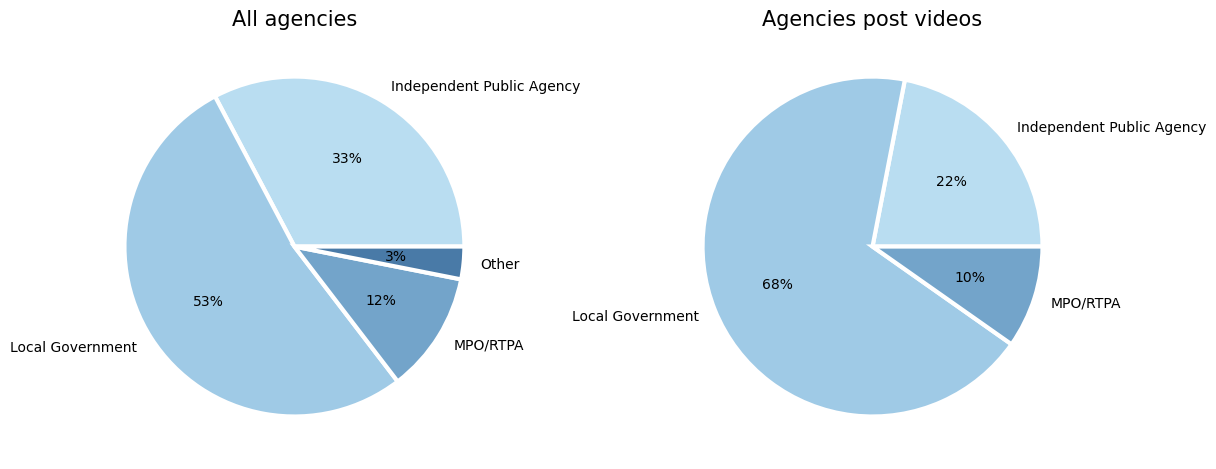

In [74]:
LG_PT = len(agency_video[agency_video['OT'] == 'Local Government'])/len(transit_survey_video[transit_survey_video['OT'] == 'Local Government'])
IPA_PT = len(agency_video[agency_video['OT'] == 'Independent Public Agency'])/len(transit_survey_video[transit_survey_video['OT'] == 'Independent Public Agency'])
MR_PT = len(agency_video[agency_video['OT'] == 'MPO/RTPA'])/len(transit_survey_video[transit_survey_video['OT'] == 'MPO/RTPA'])

print('About '+ format(LG_PT*100, '.2f') + '% Local Government is posting videos.')
print('About '+ format(IPA_PT*100, '.2f') + '% Independent Public Agency is posting videos.')
print('About '+ format(MR_PT*100, '.2f') + '% MPO/RTPA is posting videos.')


fig, axs = plt.subplots(1, 2, figsize=(12, 5))

plt.subplot(121)
plt.pie(transit_survey_video['OT'].value_counts().sort_index(), 
        labels = transit_survey_video['OT'].value_counts().sort_index().index.tolist(), 
        autopct='%.0f%%',
        wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' },
        colors = ["#B9DDF1", "#9FCAE6", "#73A4CA", "#497AA7", "#2E5B88"])
plt.title('All agencies', fontsize = 15)

plt.subplot(122)
plt.pie(agency_video['OT'].value_counts().sort_index(), 
        labels = agency_video['OT'].value_counts().sort_index().index.tolist(), 
        autopct='%.0f%%',
        wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' },
        colors = ["#B9DDF1", "#9FCAE6", "#73A4CA", "#497AA7", "#2E5B88"])

plt.title('Agencies post videos', fontsize = 15)

plt.tight_layout()
plt.savefig('Result/Video type of agency.jpg', dpi = 300)

About 55.41% Principal City is posting videos.
About 59.68% Suburban City is posting videos.
About 52.78% Small Rural City is posting videos.


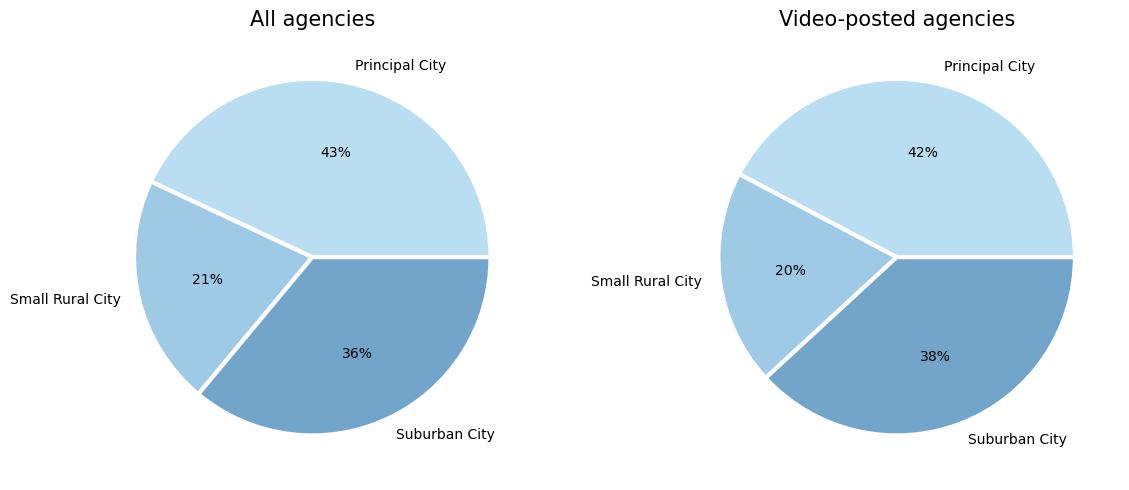

In [75]:
PC_PT = len(agency_video[agency_video['id'] == 'Principal City'])/len(transit_survey_video[transit_survey_video['id'] == 'Principal City'])
SR_PT = len(agency_video[agency_video['id'] == 'Suburban City'])/len(transit_survey_video[transit_survey_video['id'] == 'Suburban City'])
SC_PT = len(agency_video[agency_video['id'] == 'Small Rural City'])/len(transit_survey_video[transit_survey_video['id'] == 'Small Rural City'])

print('About '+ format(PC_PT*100, '.2f') + '% Principal City is posting videos.')
print('About '+ format(SR_PT*100, '.2f') + '% Suburban City is posting videos.')
print('About '+ format(SC_PT*100, '.2f') + '% Small Rural City is posting videos.')


fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# fig.suptitle('Type of cities', fontsize = 20, ha='center',va='bottom')

plt.subplot(121)
plt.pie(transit_survey_video['id'].value_counts().sort_index(), 
    labels = transit_survey_video['id'].value_counts().sort_index().index.tolist(), 
    autopct='%.0f%%',
    wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' },
    colors = ["#B9DDF1", "#9FCAE6", "#73A4CA", "#497AA7", "#2E5B88"])
plt.title('All agencies', fontsize = 15)

plt.subplot(122)
plt.pie(agency_video['id'].value_counts().sort_index(), 
    labels = agency_video['id'].value_counts().sort_index().index.tolist(), 
    autopct='%.0f%%',
    wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' },
    colors = ["#B9DDF1", "#9FCAE6", "#73A4CA", "#497AA7", "#2E5B88"])
plt.title('Video-posted agencies', fontsize = 15)

plt.tight_layout()

plt.savefig('Result/Video type of city.jpg', dpi = 300)

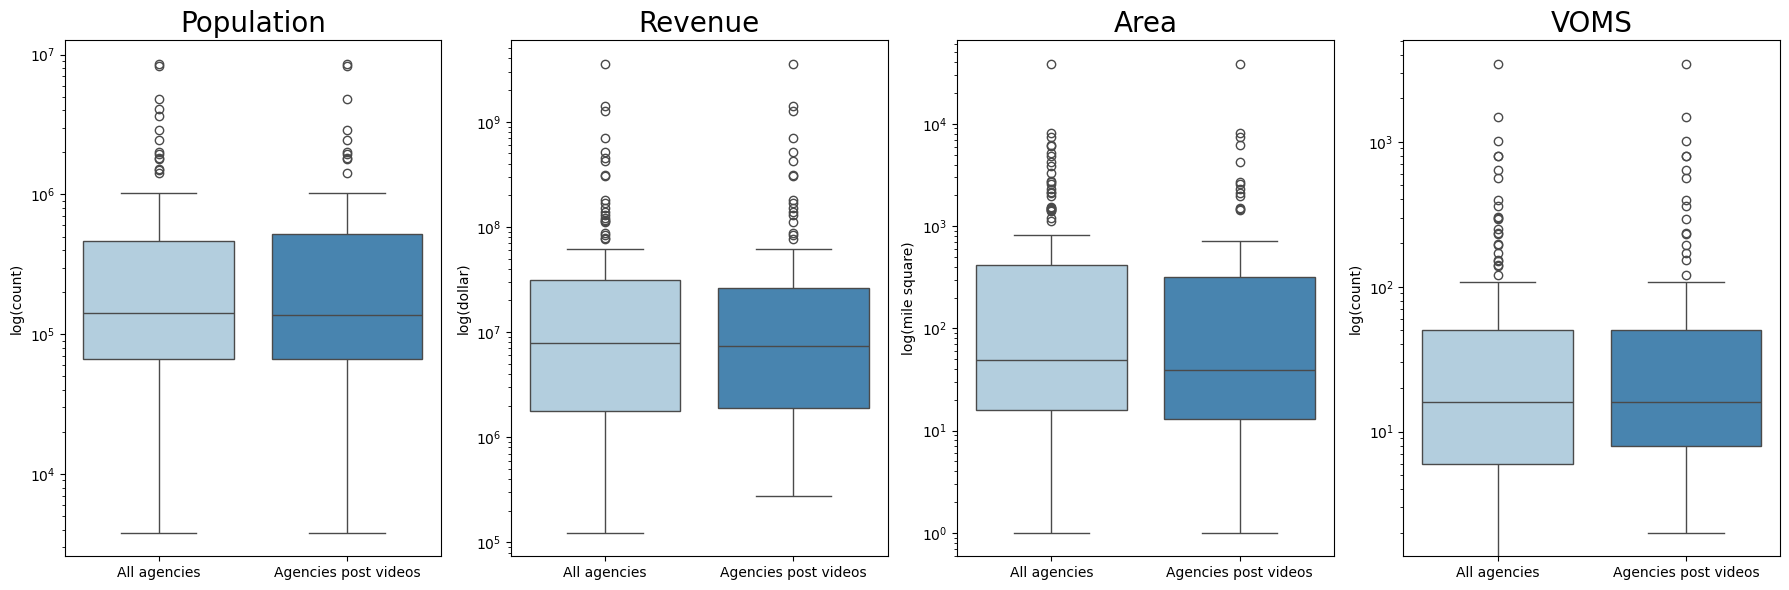

In [76]:
fig, axes = plt.subplots(1, 4, figsize=(18, 6))

plt.subplot(141)
pop = pd.concat([transit_survey_video['pop'].reset_index(drop = True).rename('All agencies'),
                 agency_video['pop'].reset_index(drop = True).rename('Agencies post videos')], axis = 1)

sns.boxplot(data = pop, palette="Blues")
plt.title('Population', fontsize = 20)
plt.ylabel('log(count)')
plt.yscale('log')

plt.subplot(142)
rev = pd.concat([transit_survey_video['revenue'].reset_index(drop = True).rename('All agencies'),
                 agency_video['revenue'].reset_index(drop = True).rename('Agencies post videos')], axis = 1)

sns.boxplot(data = rev, palette="Blues")
plt.title('Revenue', fontsize = 20)
plt.ylabel('log(dollar)')
plt.yscale('log')

plt.subplot(143)
mile = pd.concat([transit_survey_video['mile'].reset_index(drop = True).rename('All agencies'),
                 agency_video['mile'].reset_index(drop = True).rename('Agencies post videos')], axis = 1)

sns.boxplot(data = mile, palette="Blues")
plt.title('Area', fontsize = 20)
plt.ylabel('log(mile square)')
plt.yscale('log')

plt.subplot(144)
mile = pd.concat([transit_survey_video['VOMS'].reset_index(drop = True).rename('All agencies'),
                 agency_video['VOMS'].reset_index(drop = True).rename('Agencies post videos')], axis = 1)

sns.boxplot(data = mile, palette="Blues")
plt.title('VOMS', fontsize = 20)
plt.ylabel('log(count)')
plt.yscale('log')

plt.tight_layout()

plt.savefig('Result/video agencies size.jpg', dpi = 300)

In [77]:
print ('population mean: ', np.mean(agency_video['pop']))
print ('revenue mean: ', np.mean(agency_video['revenue']))
print ('VOMS mean: ', np.mean(agency_video['VOMS']))
print ('area mean: ', np.mean(agency_video['mile']))

population mean:  640574.0963855422
revenue mean:  122593173.54216868
VOMS mean:  130.8762886597938
area mean:  970.0439560439561


## Linear Regression

In [78]:
'''
Y(post_video) = a x log(pop) + c
'''

Y = log_meta['post_video']
X = log_meta[['pop']]
X = sm.add_constant(X)

results = sm.OLS(Y,X).fit()
results.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             post_video   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                   0.06192
Date:                Tue, 21 Nov 2023   Prob (F-statistic):              0.804
Time:                        10:45:32   Log-Likelihood:                -91.863
No. Observations:                 129   AIC:                             187.7
Df Residuals:                     127   BIC:                             193.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6717      0.366      1.837      0.068      -0.052       1.395
pop           -0.0075      0.030     -0.249      0.804      -0.067       0.052
==============================================================================
Omnibus:                      979.831   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.523
Skew:                          -0.330   Prob(JB):                     2.12e-05
Kurtosis:                       1.111   Cond. No.                         102.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [79]:
'''
Y(post_video) = a x log(revenue) + c
'''

Y = log_meta['post_video']
X = log_meta[['revenue']]
X = sm.add_constant(X)

results = sm.OLS(Y,X).fit()
results.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             post_video   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                  0.009530
Date:                Tue, 21 Nov 2023   Prob (F-statistic):              0.922
Time:                        10:45:33   Log-Likelihood:                -91.890
No. Observations:                 129   AIC:                             187.8
Df Residuals:                     127   BIC:                             193.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5486      0.339      1.620      0.108      -0.122       1.219
revenue        0.0021      0.021      0.098      0.922      -0.040       0.044
==============================================================================
Omnibus:                      978.024   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.557
Skew:                          -0.330   Prob(JB):                     2.08e-05
Kurtosis:                       1.109   Cond. No.                         125.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [80]:
'''
Y(post_video) = a x log(mile) + c
'''

Y = log_meta['post_video']
X = log_meta[['mile']]
X = sm.add_constant(X)

results = sm.OLS(Y,X).fit()
results.summary()  


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             post_video   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     4.373
Date:                Tue, 21 Nov 2023   Prob (F-statistic):             0.0385
Time:                        10:45:34   Log-Likelihood:                -89.711
No. Observations:                 129   AIC:                             183.4
Df Residuals:                     127   BIC:                             189.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7777      0.103      7.530      0.000       0.573       0.982
mile          -0.0503      0.024     -2.091      0.039      -0.098      -0.003
==============================================================================
Omnibus:                     1202.087   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.755
Skew:                          -0.308   Prob(JB):                     8.46e-05
Kurtosis:                       1.236   Cond. No.                         10.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [81]:
'''
Y(post_video) = a x log(VOMS) + c
'''

Y = log_meta['post_video']
X = log_meta[['VOMS']]
X = sm.add_constant(X)

results = sm.OLS(Y,X).fit()
results.summary()  


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             post_video   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                   0.03968
Date:                Tue, 21 Nov 2023   Prob (F-statistic):              0.842
Time:                        10:45:47   Log-Likelihood:                -91.875
No. Observations:                 129   AIC:                             187.7
Df Residuals:                     127   BIC:                             193.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5630      0.102      5.519      0.000       0.361       0.765
VOMS           0.0054      0.027      0.199      0.842      -0.049       0.060
==============================================================================
Omnibus:                      979.133   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.538
Skew:                          -0.330   Prob(JB):                     2.10e-05
Kurtosis:                       1.110   Cond. No.                         9.22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
'''
Y(post_video) = a x log(pop) + b x log(revenue) + c
'''

Y = log_meta['post_video']
X = log_meta[['pop', 'revenue']]
X = sm.add_constant(X)

results = sm.OLS(Y,X).fit()
results.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             post_video   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.2057
Date:                Tue, 21 Nov 2023   Prob (F-statistic):              0.814
Time:                        10:05:12   Log-Likelihood:                -91.684
No. Observations:                 129   AIC:                             189.4
Df Residuals:                     126   BIC:                             197.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6418      0.370      1.735      0.085      -0.090       1.374
pop           -0.0366      0.058     -0.634      0.527      -0.151       0.078
revenue        0.0238      0.040      0.591      0.555      -0.056       0.104
==============================================================================
Omnibus:                      992.567   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.319
Skew:                          -0.330   Prob(JB):                     2.35e-05
Kurtosis:                       1.121   Cond. No.                         171.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
'''
Y(post_video) = a x log(pop) + b x log(mile) + c
'''

Y = log_meta['post_video']
X = log_meta[['pop', 'mile']]
X = sm.add_constant(X)

results = sm.OLS(Y,X).fit()
results.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             post_video   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     4.576
Date:                Tue, 21 Nov 2023   Prob (F-statistic):             0.0121
Time:                        10:05:12   Log-Likelihood:                -87.372
No. Observations:                 129   AIC:                             180.7
Df Residuals:                     126   BIC:                             189.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1710      0.451     -0.379      0.705      -1.064       0.722
pop            0.0985      0.046      2.157      0.033       0.008       0.189
mile          -0.1119      0.037     -3.014      0.003      -0.185      -0.038
==============================================================================
Omnibus:                     3275.495   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.288
Skew:                          -0.359   Prob(JB):                     0.000290
Kurtosis:                       1.414   Cond. No.                         138.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Correlation Plot

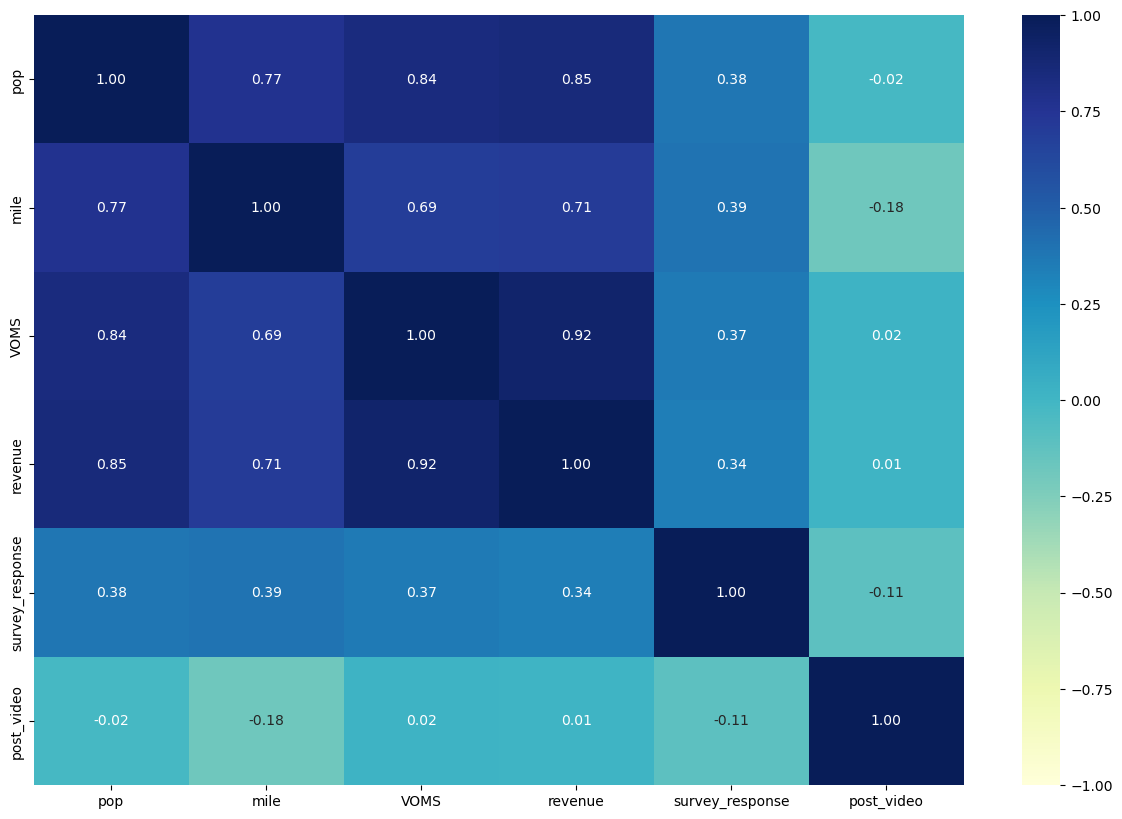

In [50]:
plt.figure(figsize=[15, 10])
corr_matrix = log_meta[['pop','mile', 'VOMS', 'revenue', 'survey_response', 'post_video']].corr()
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu", vmin=-1, vmax=1, fmt = '.2f')

plt.savefig('Result/correlation matrix all.jpg', dpi = 300)
plt.show()

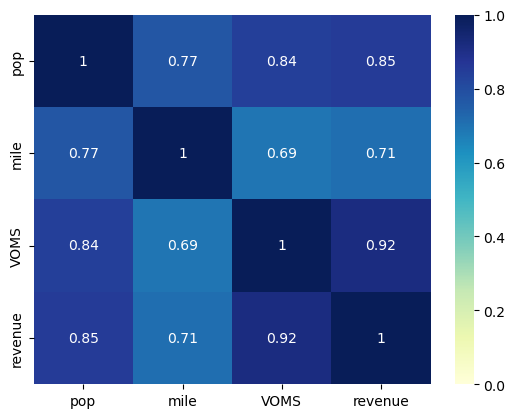

In [44]:
corr_matrix = log_meta[['pop','mile', 'VOMS', 'revenue']].corr()
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu", vmin=0, vmax=1)
plt.savefig('Result/correlation matrix.jpg', dpi = 300)